In [1]:
!unzip 'data_raw.zip'
!pip install split-folders

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: data_raw/Silver/Nissan$$Juke$$2017$$Silver$$64_14$$2661$$image_4.jpg  
  inflating: data_raw/Silver/Nissan$$Juke$$2017$$Silver$$64_14$$2661$$image_41.jpg  
  inflating: data_raw/Silver/Nissan$$Juke$$2017$$Silver$$64_14$$2699$$image_0.jpg  
  inflating: data_raw/Silver/Nissan$$Juke$$2017$$Silver$$64_14$$2699$$image_3.jpg  
  inflating: data_raw/Silver/Nissan$$Juke$$2017$$Silver$$64_14$$2699$$image_4.jpg  
  inflating: data_raw/Silver/Nissan$$Juke$$2017$$Silver$$64_14$$2699$$image_6.jpg  
  inflating: data_raw/Silver/Nissan$$Juke$$2017$$Silver$$64_14$$2792$$image_0.jpg  
  inflating: data_raw/Silver/Nissan$$Juke$$2017$$Silver$$64_14$$2792$$image_4.jpg  
  inflating: data_raw/Silver/Nissan$$Juke$$2017$$Silver$$64_14$$2792$$image_6.jpg  
  inflating: data_raw/Silver/Nissan$$Juke$$2017$$Silver$$64_14$$2797$$image_0.jpg  
  inflating: data_raw/Silver/Nissan$$Juke$$2017$$Silver$$64_14$$2797$$image_1.jpg  
  infla

In [1]:
import splitfolders

splitfolders.ratio('data_raw', output='data', ratio=(0.8, 0.0, 0.2))

Copying files: 23388 files [00:35, 663.10 files/s]


In [2]:
from torchvision import transforms as T, datasets

img_size = 300
normalize = T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])

train_transforms = T.Compose([
        T.Resize((img_size, img_size)),
        T.RandomHorizontalFlip(),
        T.RandomRotation(degrees=30),
        T.ToTensor(),
        normalize
    ])

test_transforms = T.Compose([
    T.Resize((img_size, img_size)),
    T.ToTensor(),
    normalize
])

In [3]:
train_dataset = datasets.ImageFolder(root='data/train', transform=train_transforms)

In [4]:
n_classes = len(train_dataset.classes)
print(n_classes)
classes = train_dataset.classes
classes

17


['Beige',
 'Black',
 'Blue',
 'Bronze',
 'Brown',
 'Gold',
 'Green',
 'Grey',
 'Maroon',
 'Multicolour',
 'Orange',
 'Pink',
 'Purple',
 'Red',
 'Silver',
 'White',
 'Yellow']

<BarContainer object of 17 artists>

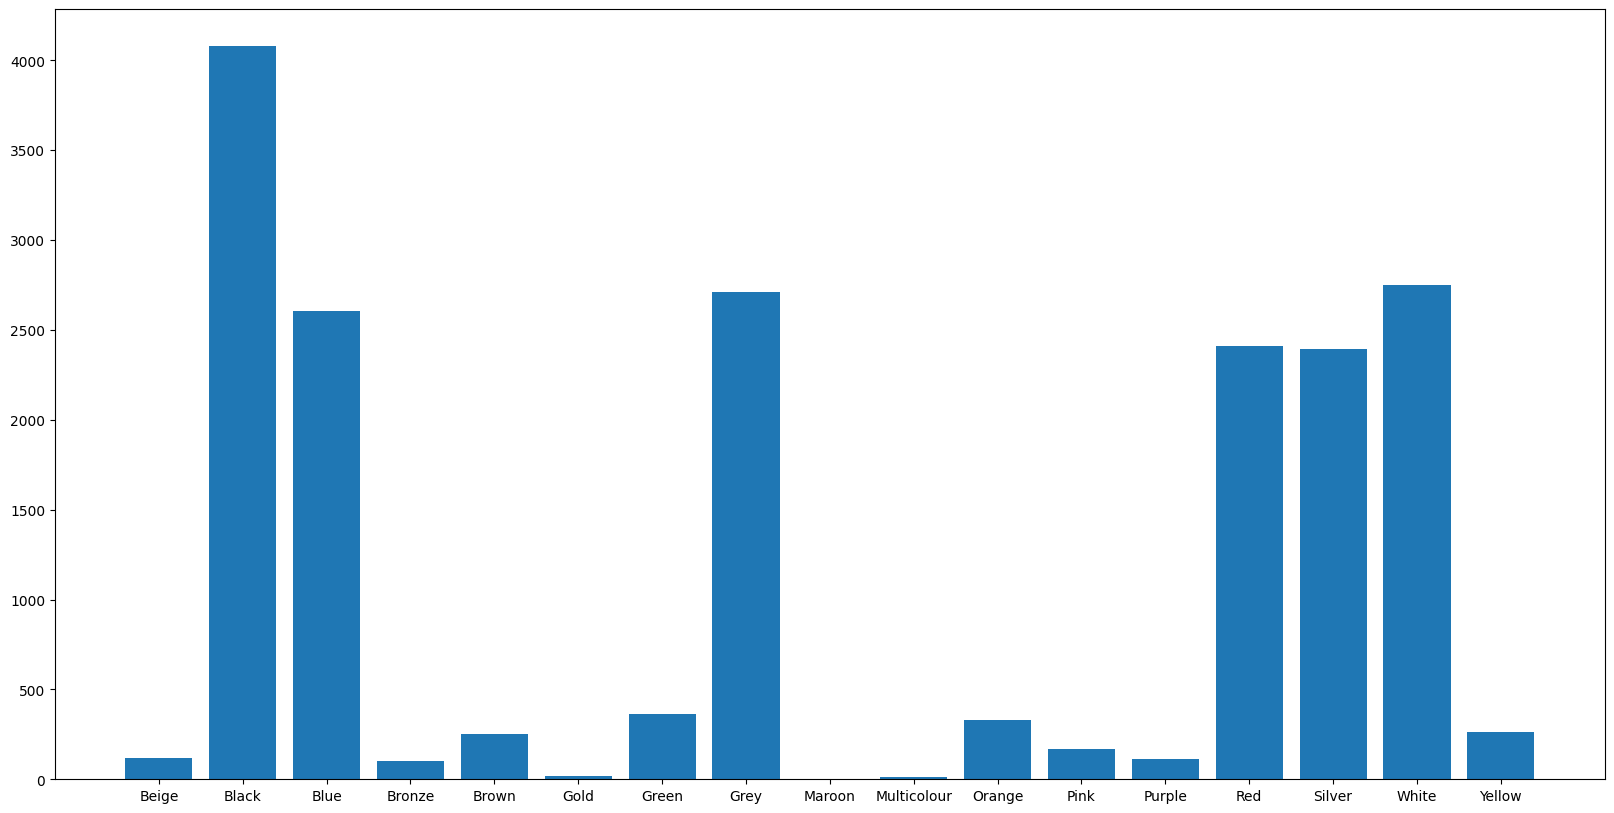

In [7]:
import matplotlib.pyplot as plt
import numpy as np

counts, _ = np.histogram(train_dataset.targets, bins=n_classes)
plt.figure(figsize=(20,10))
plt.bar(classes, counts)

In [8]:
min_count = 2000
n_frequent = np.count_nonzero(counts > min_count)
sorted_indices = np.argsort(counts)[::-1][:n_frequent]
freq_classes = [classes[i] for i in sorted_indices] + ['Other']
print(freq_classes)
label_mapping = { c: np.where(sorted_indices == c)[0][0] if counts[c] > min_count else n_frequent for c in range(n_classes) }
label_mapping

['Black', 'White', 'Grey', 'Blue', 'Red', 'Silver', 'Other']


{0: 6,
 1: 0,
 2: 3,
 3: 6,
 4: 6,
 5: 6,
 6: 6,
 7: 2,
 8: 6,
 9: 6,
 10: 6,
 11: 6,
 12: 6,
 13: 4,
 14: 5,
 15: 1,
 16: 6}

In [9]:
train_dataset = datasets.ImageFolder(
    root='data/train',
    transform=train_transforms,
    target_transform=lambda l: label_mapping[l] if l in label_mapping else n_frequent
)
test_dataset = datasets.ImageFolder(
    root='data/test',
    transform=test_transforms,
    target_transform=lambda l: label_mapping[l] if l in label_mapping else n_frequent
)

<BarContainer object of 7 artists>

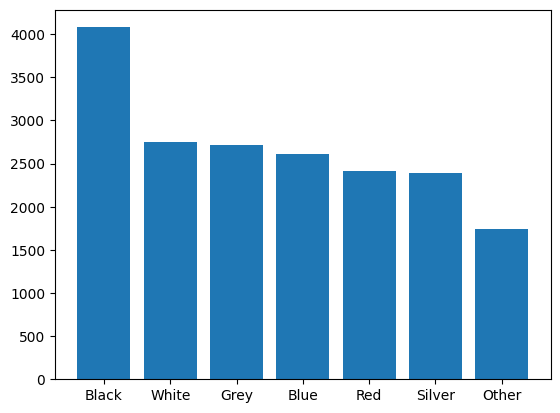

In [10]:
n_classes = n_frequent + 1
classes = freq_classes

targets = [target for _, target in train_dataset]
counts, _ = np.histogram(targets, bins=n_classes)
plt.bar(classes, counts)

In [19]:
from torch.utils.data import DataLoader

batch_size = 8

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Other


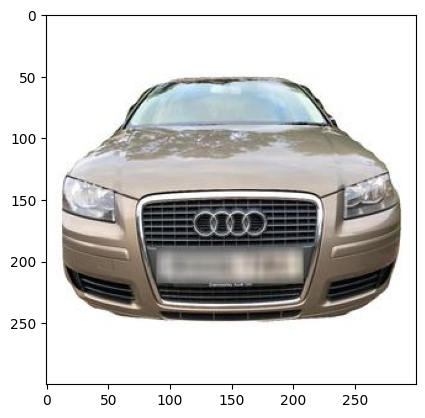

In [20]:
from PIL import Image

sample_img, sample_label = train_dataset.imgs[0]
print(classes[label_mapping[sample_label]])
plt.imshow(Image.open(sample_img))

Silver


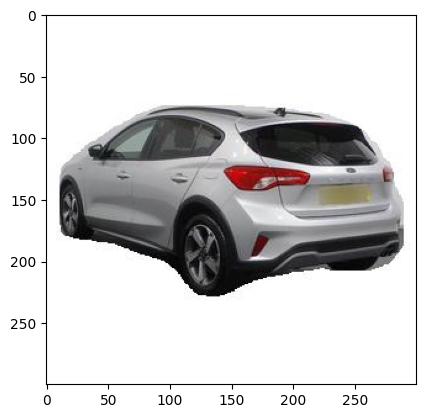

In [21]:
sample_img, sample_label = train_dataset.imgs[13_999]
print(classes[label_mapping[sample_label]])
plt.imshow(Image.open(sample_img))

In [22]:
import torch
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.downsample = downsample

    def forward(self, x):
        if self.downsample is not None:
            identity = self.downsample(x)
        else:
            identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):
    def __init__(self, blocks=(2, 2, 2, 2)):
        super().__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(64, blocks[0])
        self.layer2 = self._make_layer(128, blocks[1], stride=2)
        self.layer3 = self._make_layer(256, blocks[2], stride=2)
        self.layer4 = self._make_layer(512, blocks[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, n_classes)

    def _make_layer(self, out_channels, blocks, stride=1):
        if stride != 1 or out_channels != self.in_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )
        else:
            downsample = None

        layers = [
            ResidualBlock(self.in_channels, out_channels, stride=stride, downsample=downsample)
        ]

        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(
                ResidualBlock(self.in_channels, out_channels)
            )

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [23]:
resnet_model = ResNet()

batch_data, batch_labels = next(train_loader.__iter__())
pred = resnet_model(batch_data)
print(pred, batch_labels)

tensor([[-0.7703,  0.4542, -1.2522, -0.7329, -0.0632,  0.3975,  0.5153],
        [-0.7068,  0.3581, -1.1165, -0.6151,  0.0464,  0.5338,  0.4763],
        [-0.6701,  0.3848, -0.8892, -0.5012,  0.0131,  0.5677,  0.3802],
        [-0.6670,  0.3525, -0.9654, -0.6355,  0.0107,  0.5761,  0.5431],
        [-0.7080,  0.3848, -0.9583, -0.4668,  0.0707,  0.4412,  0.4062],
        [-0.7612,  0.3924, -1.0103, -0.5736,  0.1285,  0.4549,  0.4572],
        [-0.7223,  0.3763, -1.0671, -0.6219, -0.0577,  0.3869,  0.5264],
        [-0.6635,  0.3591, -1.1550, -0.5900,  0.0789,  0.5506,  0.5780]],
       grad_fn=<AddmmBackward0>) tensor([0, 6, 5, 1, 3, 5, 2, 5])


In [24]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [25]:
from tqdm import tqdm
from sklearn.metrics import f1_score

resnet_model = ResNet(blocks=(3, 4, 6, 3)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet_model.parameters())

epochs = 20

def train_model(model):
    model.train()
    track_loss = []

    for (data, labels) in tqdm(train_loader):
        data, labels = data.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        track_loss.append(loss.item())

    return np.mean(track_loss)

def test_model(model):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for (data, labels) in tqdm(test_loader):
            data, labels = data.to(device), labels.to(device)

            pred = model(data)
            pred_probs = torch.softmax(pred, dim=1)
            pred_labels = torch.argmax(pred_probs, dim=1)

            y_true += labels.detach().cpu()
            y_pred += pred_labels.detach().cpu()

    return f1_score(y_true, y_pred, average='macro')

In [26]:
loss = []
score = []

for epoch in range(epochs):
    print(f"Epoch {epoch}")

    print("Training model")
    epoch_loss = train_model(resnet_model)
    loss.append(epoch_loss)
    print(f"Train loss: {epoch_loss}")

    print("Testing model")
    epoch_score = test_model(resnet_model)
    score.append(epoch_score)
    print(f"Test f1-score: {epoch_score}\n")

Epoch 0
Training model


  3%|▎         | 75/2338 [02:33<1:17:04,  2.04s/it]


KeyboardInterrupt: 

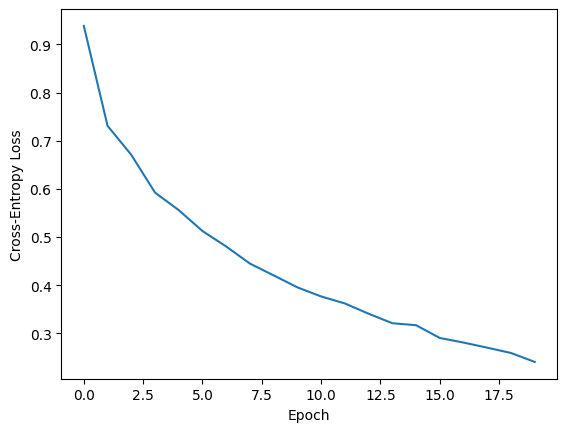

In [ ]:
plt.plot(loss)
plt.xlabel('Epoch')
plt.ylabel('Cross-Entropy Loss')
plt.show()

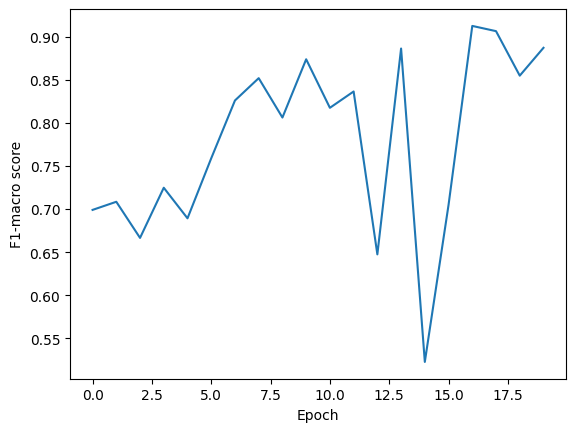

In [ ]:
plt.plot(score)
plt.xlabel('Epoch')
plt.ylabel('F1-macro score')
plt.show()

True label: Silver
Predicted label: Silver


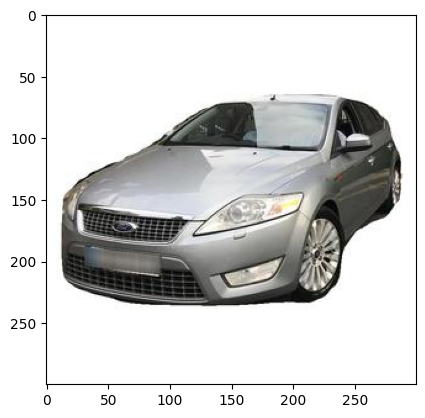

In [ ]:
def sample_test_loader():
  lim = np.random.randint(len(test_dataset) // batch_size)
  k = 0
  for b, _ in test_loader:
    if k >= lim:
      return b, k
    k += 1

sample_ix = 3
batch, batch_ix = sample_test_loader()
batch = batch.to(device)

pred_labels = torch.argmax(resnet_model(batch), dim=1).detach().cpu()
pred_label_ix = pred_labels[sample_ix]
sample_img, true_label_ix = test_dataset.imgs[batch_ix * batch_size + sample_ix]

print(f"True label: {classes[true_label_ix]}")
print(f"Predicted label: {classes[pred_label_ix]}")
plt.imshow(Image.open(sample_img))

In [ ]:
from torchvision import models

def get_pretrained_model():
  resnet = models.resnet34(weights=models.ResNet34_Weights.DEFAULT).to(device)
  resnet.requires_grad_(False)
  resnet.fc = nn.Linear(512, n_classes)
  return resnet

pretrained_model = get_pretrained_model().to(device)

In [ ]:
pretrained_loss = []
pretrained_score = []

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(pretrained_model.parameters())

for epoch in range(epochs):
    print(f"Epoch {epoch}")

    print("Training model")
    epoch_loss = train_model(pretrained_model)
    pretrained_loss.append(epoch_loss)
    print(f"Train loss: {epoch_loss}")

    print("Testing model")
    epoch_score = test_model(pretrained_model)
    pretrained_score.append(epoch_score)
    print(f"Test f1-score: {epoch_score}")

Epoch 0
Training model


100%|██████████| 431/431 [01:34<00:00,  4.55it/s]


Train loss: 1.0640162319428959


100%|██████████| 108/108 [00:18<00:00,  5.73it/s]


Test f1-score: 0.6797721236574749
Epoch 1
Training model


100%|██████████| 431/431 [01:28<00:00,  4.84it/s]


Train loss: 0.7280718943497421


100%|██████████| 108/108 [00:18<00:00,  5.88it/s]


Test f1-score: 0.7134372770798693
Epoch 2
Training model


100%|██████████| 431/431 [01:26<00:00,  5.00it/s]


Train loss: 0.6600476161786409


100%|██████████| 108/108 [00:21<00:00,  5.10it/s]


Test f1-score: 0.7311129351913014
Epoch 3
Training model


100%|██████████| 431/431 [01:32<00:00,  4.65it/s]


Train loss: 0.6276898022455848


100%|██████████| 108/108 [00:19<00:00,  5.54it/s]


Test f1-score: 0.7391038090973486
Epoch 4
Training model


100%|██████████| 431/431 [01:26<00:00,  4.99it/s]


Train loss: 0.6074210085199493


100%|██████████| 108/108 [00:19<00:00,  5.64it/s]


Test f1-score: 0.7468368291805992
Epoch 5
Training model


100%|██████████| 431/431 [01:26<00:00,  4.98it/s]


Train loss: 0.589406342904695


100%|██████████| 108/108 [00:19<00:00,  5.65it/s]


Test f1-score: 0.733598865857431
Epoch 6
Training model


100%|██████████| 431/431 [01:29<00:00,  4.80it/s]


Train loss: 0.5792898983109025


100%|██████████| 108/108 [00:20<00:00,  5.19it/s]


Test f1-score: 0.748836350216732
Epoch 7
Training model


100%|██████████| 431/431 [01:40<00:00,  4.31it/s]


Train loss: 0.5708251016045944


100%|██████████| 108/108 [00:21<00:00,  5.10it/s]


Test f1-score: 0.7737866636842657
Epoch 8
Training model


100%|██████████| 431/431 [01:34<00:00,  4.55it/s]


Train loss: 0.5628731592348722


100%|██████████| 108/108 [00:22<00:00,  4.85it/s]


Test f1-score: 0.7743554160352581
Epoch 9
Training model


100%|██████████| 431/431 [01:36<00:00,  4.47it/s]


Train loss: 0.548759945480287


100%|██████████| 108/108 [00:21<00:00,  4.93it/s]


Test f1-score: 0.7769251042690573
Epoch 10
Training model


100%|██████████| 431/431 [01:35<00:00,  4.50it/s]


Train loss: 0.5518998059416038


100%|██████████| 108/108 [00:19<00:00,  5.46it/s]


Test f1-score: 0.757900853296677
Epoch 11
Training model


100%|██████████| 431/431 [01:39<00:00,  4.33it/s]


Train loss: 0.5514417752934719


100%|██████████| 108/108 [00:18<00:00,  5.83it/s]


Test f1-score: 0.7588766684540033
Epoch 12
Training model


100%|██████████| 431/431 [01:40<00:00,  4.27it/s]


Train loss: 0.5318289528797508


100%|██████████| 108/108 [00:21<00:00,  4.98it/s]


Test f1-score: 0.7813804780702656
Epoch 13
Training model


100%|██████████| 431/431 [01:33<00:00,  4.60it/s]


Train loss: 0.5383016147289917


100%|██████████| 108/108 [00:22<00:00,  4.75it/s]


Test f1-score: 0.7880092364306656
Epoch 14
Training model


100%|██████████| 431/431 [01:36<00:00,  4.48it/s]


Train loss: 0.5331581086266068


100%|██████████| 108/108 [00:19<00:00,  5.49it/s]


Test f1-score: 0.7824978856809577
Epoch 15
Training model


100%|██████████| 431/431 [01:41<00:00,  4.25it/s]


Train loss: 0.5253589189591927


100%|██████████| 108/108 [00:23<00:00,  4.65it/s]


Test f1-score: 0.7841727728226583
Epoch 16
Training model


100%|██████████| 431/431 [01:34<00:00,  4.56it/s]


Train loss: 0.5248205902750697


100%|██████████| 108/108 [00:23<00:00,  4.68it/s]


Test f1-score: 0.7690076404653058
Epoch 17
Training model


100%|██████████| 431/431 [01:31<00:00,  4.70it/s]


Train loss: 0.5191006721656449


100%|██████████| 108/108 [00:23<00:00,  4.64it/s]


Test f1-score: 0.7797067593151904
Epoch 18
Training model


100%|██████████| 431/431 [01:36<00:00,  4.48it/s]


Train loss: 0.5258744121151014


100%|██████████| 108/108 [00:23<00:00,  4.65it/s]


Test f1-score: 0.7989656389299205
Epoch 19
Training model


100%|██████████| 431/431 [01:40<00:00,  4.29it/s]


Train loss: 0.5241085297132037


100%|██████████| 108/108 [00:22<00:00,  4.85it/s]


Test f1-score: 0.7689252355222185


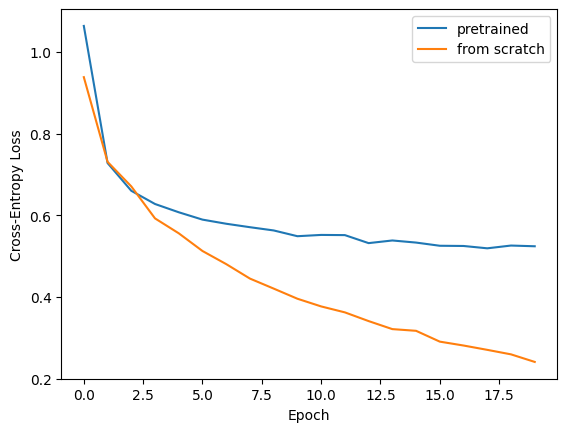

In [ ]:
plt.plot(pretrained_loss, label='pretrained')
plt.plot(loss, label='from scratch')
plt.xlabel('Epoch')
plt.ylabel('Cross-Entropy Loss')
plt.legend()
plt.show()

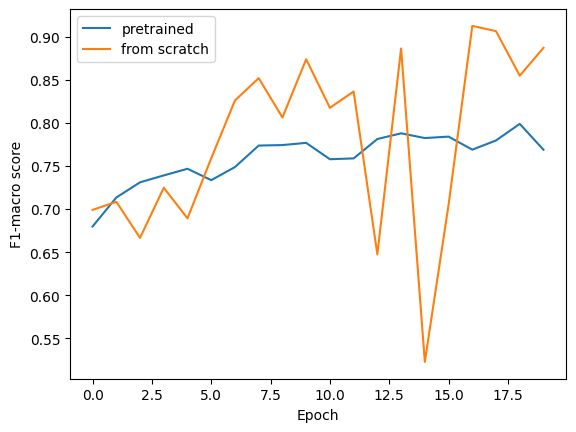

In [ ]:
plt.plot(pretrained_score, label='pretrained')
plt.plot(score, label='from scratch')
plt.xlabel('Epoch')
plt.ylabel('F1-macro score')
plt.legend()
plt.show()

In [ ]:
resnet_ckpt_path = 'my_trained_resnet.pth'
torch.save(resnet_model.state_dict(), resnet_ckpt_path)